In [1]:
import numpy as np
import xarray as xr
import MJO_E3SM_util as mjo
import pandas as pd 
import matplotlib.pyplot as plt 

# calculate the MSE budget 
# The composites are based on Ma's paper

# directory that stores all case data
dirn = '/pscratch/sd/l/linyaoly/MJO_E3SM/regridded_data/'
# specify which case we use
case_dir = 'control'

lat_lim = 10

# read all files in the case directory
import glob
files_path = dirn + case_dir + '/3D/'

# Find all .nc files in the directory
nc_files = sorted(glob.glob(f"{files_path}/*.nc"))

ds = xr.open_mfdataset(nc_files)

files_path = dirn + case_dir + '/'

# Find all .nc files in the directory
nc_files = sorted(glob.glob(f"{files_path}/*.nc"))

ds1 = xr.open_mfdataset(nc_files)

# average the OLR over 10S-10N
olr = ds1['FLNT'].sel(lat=slice(-lat_lim,lat_lim)).resample(time='1D').mean().load()
olravg = olr.mean(dim='lat') # average over 10S-10N

# filter the olr data (k=1-9, f=0.01-0.05)
# olravg[time, lon]

olrflt = mjo.get_MJO_signal(olravg, d=1, kmin=1, kmax=9, flow=0.01, fhig=0.05)
# get the location of the miminum OLR
olrmin = olrflt.argmin(dim='lon')

mse_budget = mjo.get_local_MSE_budget(ds, lat_lim=lat_lim, plim=100, latmean=True)


KeyboardInterrupt: 

In [ ]:
import pickle

# Write to a JSON file MJO_E3SM/regridded_data/analysis/local_MSE_budget
with open(dirn+'analysis/local_MSE_budget/local_MSE_budget_control_latavg.json', 'wb') as file:
    pickle.dump(mse_budget, file)

print('budget saved')

In [ ]:
from concurrent.futures import ProcessPoolExecutor

def process_key(key, mse_data, olrmin):
    """Function to process mse data for a given key."""
    mse_ano = mse_data - mse_data.mean(dim='lon')
    mse_sft = np.empty_like(mse_ano)

    for i in range(olrmin.size):
        mse_sft[i, :, :] = np.roll(mse_ano[i, :, :], shift=90 - olrmin[i], axis=-1)

    return key, mse_sft.mean(dim='time')

def get_local_MSE_budget_composite_parallel(mse_budget, olrmin):
    comp = {}

    # Prepare arguments for each process
    args = [(key, mse_budget[key], olrmin) for key in mse_budget.keys()]

    # Using ProcessPoolExecutor to parallelize the computation for each key
    with ProcessPoolExecutor() as executor:
        for key, result in executor.map(lambda p: process_key(*p), args):
            comp[key] = result

    return comp


In [ ]:
comp = get_local_MSE_budget_composite_parallel(mse_budget, olrmin)

# Write to a JSON file MJO_E3SM/regridded_data/analysis/local_MSE_budget
with open(dirn+'analysis/local_MSE_budget/local_MSE_budget_composite_control_latavg.json', 'wb') as file:
    pickle.dump(comp, file)


In [1]:
import numpy as np
import xarray as xr 
import matplotlib.pyplot as plt

In [1]:
import numpy as np
import xarray as xr
import MJO_E3SM_util as mjo
import pandas as pd 
import matplotlib.pyplot as plt 

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# directory that stores all case data
dirn = '/pscratch/sd/l/linyaoly/MJO_E3SM/regridded_data/'
# specify which case we use
case_dir = 'control'

lat_lim = 30

ndays = 1

import glob
files_path = dirn + case_dir + '/3D/'

# Find all .nc files in the directory
nc_files = sorted(glob.glob(f"{files_path}/*.nc"))

ds = xr.open_dataset(nc_files[-ndays])
ds 

<xarray.Dataset>
Dimensions:       (lat: 90, lon: 180, nbnd: 2, time: 1, lev: 60, ilev: 61,
                   lwband: 16, swband: 14)
Coordinates:
  * lat           (lat) float64 -89.0 -87.0 -85.0 -83.0 ... 83.0 85.0 87.0 89.0
  * lon           (lon) float64 1.0 3.0 5.0 7.0 9.0 ... 353.0 355.0 357.0 359.0
  * ilev          (ilev) float64 0.05588 0.1008 0.1814 ... 970.8 985.3 1e+03
  * lev           (lev) float64 0.07835 0.1411 0.2529 ... 963.6 978.0 992.6
  * lwband        (lwband) float64 130.0 375.0 565.0 ... 2.535e+03 2.965e+03
  * swband        (swband) float64 2.925e+03 3.625e+03 ... 4.4e+04 1.71e+03
  * time          (time) object 0010-05-16 00:00:00
Dimensions without coordinates: nbnd
Data variables: (12/52)
    lat_bnds      (lat, nbnd) float64 ...
    lon_bnds      (lon, nbnd) float64 ...
    gw            (lat) float64 ...
    area          (lat, lon) float64 ...
    CLDICE        (time, lev, lat, lon) float32 ...
    CLDLIQ        (time, lev, lat, lon) float32 ...
    ...            ...
    nsbase        int32 ...
    nscur         (time) int32 ...
    nsteph        (time) int32 ...
    sol_tsi       (time) float64 ...
    time_bnds     (time, nbnd) object ...
    time_written  (time) |S8 ...
Attributes: (12/26)
    ne:                        30
    fv_nphys:                  2
    title:                     EAM History file information
    source:                    E3SM Atmosphere Model
    source_id:                 75e954ad3f
    product:                   model-output
    ...                        ...
    remap_hostname:            login02
    remap_version:             5.1.4
    NCO:                       netCDF Operators version 5.1.4 (Homepage = htt...
    nco_openmp_thread_number:  2
    map_file:                  /global/homes/l/linyaoly/MJO_E3SM/remap/map_ne...
    input_file:                /global/cfs/cdirs/m3312/whannah/2022-RCEROT/E3...

In [4]:
mse_budget = {}
lat_avg = 5
plim = 100 
dtmse_sel = mjo.get_local_MSE_tendency(ds, lat_lim=lat_avg).load().copy() # [lev, lat, lon]
raw_dtmse = dtmse_sel.sel(lev=slice(plim,None)).mean(['lat'])  # [lev, lon]
mse_budget['tendency'] = raw_dtmse * 86400

# get local MSE source: CRM + PBL
dtmse_sel = (mjo.get_local_MSE_source(ds,'DDSE_CRM_ALT',lat_lim=lat_avg).load().copy()
            + mjo.get_local_MSE_source(ds,'DQLV_CRM_ALT',lat_lim=lat_avg).load().copy()
            + mjo.get_local_MSE_source(ds,'DDSE_PBL',lat_lim=lat_avg).load().copy()
            + mjo.get_local_MSE_source(ds,'DQLV_PBL',lat_lim=lat_avg).load().copy()
            - mjo.get_local_MSE_source(ds,'DDSE_QRS',lat_lim=lat_avg).load().copy()
            - mjo.get_local_MSE_source(ds,'DDSE_QRL',lat_lim=lat_avg).load().copy())

raw_dtmse = dtmse_sel.sel(lev=slice(plim,None)).mean('lat')  # [lev, lon]
mse_budget['crmpbl'] = raw_dtmse * 86400

dtmse_sel = mjo.get_local_MSE_source(ds,'DDSE_QRS',lat_lim=lat_avg).load().copy() + mjo.get_local_MSE_source(ds,'DDSE_QRL',lat_lim=lat_avg).load() 
raw_dtmse = dtmse_sel.sel(lev=slice(plim,None)).mean('lat')  # [lev, lon]
mse_budget['qr'] = raw_dtmse * 86400

dtmse_sel = mjo.get_local_MSE_source(ds,'DDSE_DYN',lat_lim=lat_avg).load().copy() + mjo.get_local_MSE_source(ds,'DQLV_DYN',lat_lim=lat_avg).load() 
raw_dtmse = dtmse_sel.sel(lev=slice(plim,None)).mean(['lat'])  # [lev, lon]
mse_budget['dyn'] = raw_dtmse * 86400

dtmse_sel = mjo.get_local_MSE_source(ds,'DDSE_CEF',lat_lim=lat_avg).load().copy() + mjo.get_local_MSE_source(ds,'DQLV_CEF',lat_lim=lat_avg).load() 
raw_dtmse = dtmse_sel.sel(lev=slice(plim,None)).mean(['lat'])  # [lev, lon]
mse_budget['cef'] = raw_dtmse * 86400

dtmse_sel = mjo.get_local_MSE_source(ds,'DDSE_GWD',lat_lim=lat_avg).load().copy() 
raw_dtmse = dtmse_sel.sel(lev=slice(plim,None)).mean(['lat'])  # [lev, lon]
mse_budget['gwd'] = raw_dtmse * 86400

resi = mse_budget['tendency'] - mse_budget['crmpbl'] - mse_budget['qr'] - mse_budget['dyn'] - mse_budget['gwd'] - mse_budget['cef']


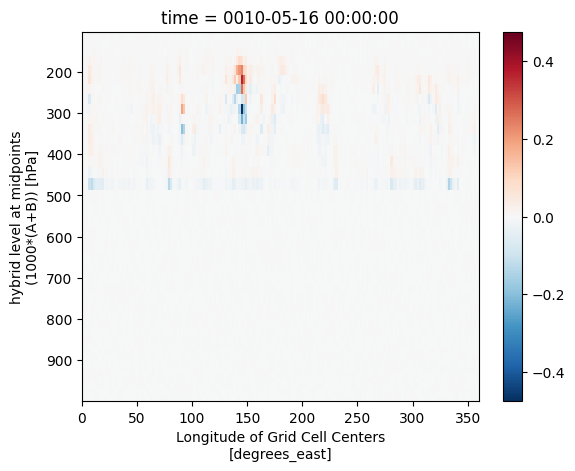

In [5]:
resi.plot()
plt.gca().invert_yaxis()

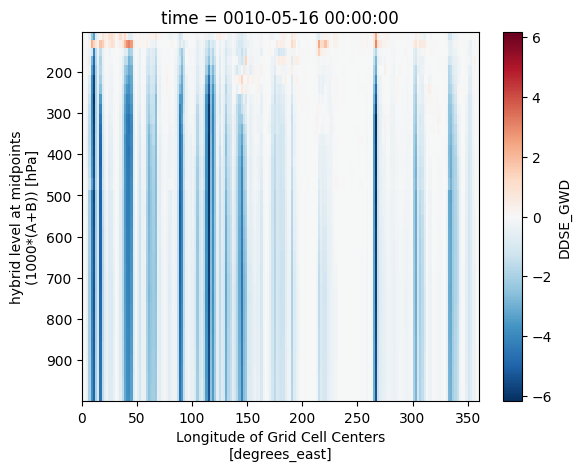

In [6]:
mse_budget['gwd'].plot()
plt.gca().invert_yaxis()

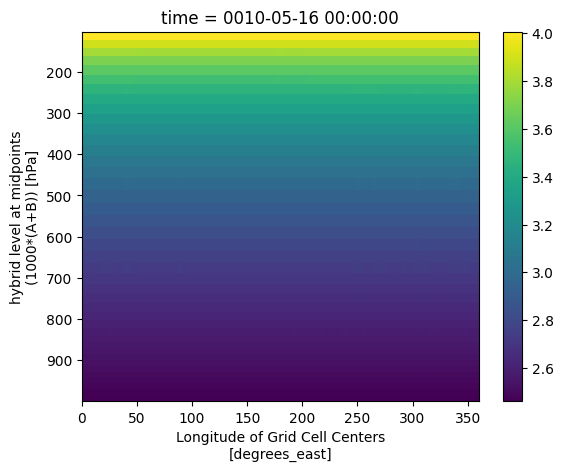

In [8]:
mse_budget['cef'].plot()
plt.gca().invert_yaxis()

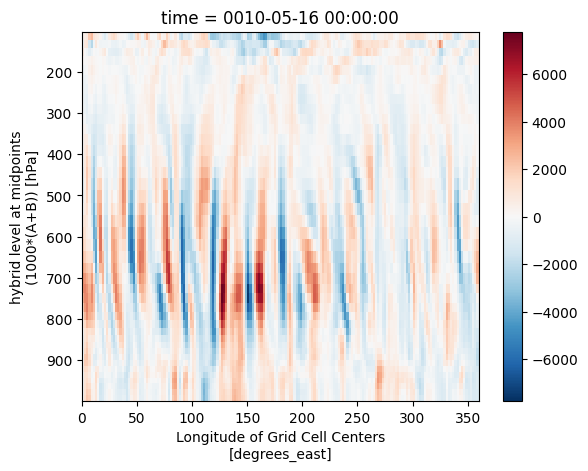

In [9]:
cbar = mse_budget['tendency'].plot()
plt.gca().invert_yaxis()
cbar.set_label('MSE tendency')

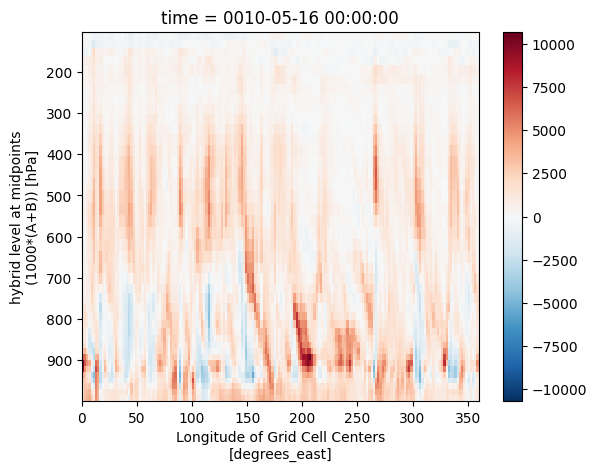

In [10]:
cbar = mse_budget['crmpbl'].plot()
plt.gca().invert_yaxis()
cbar.set_label('CRM+PBL')   

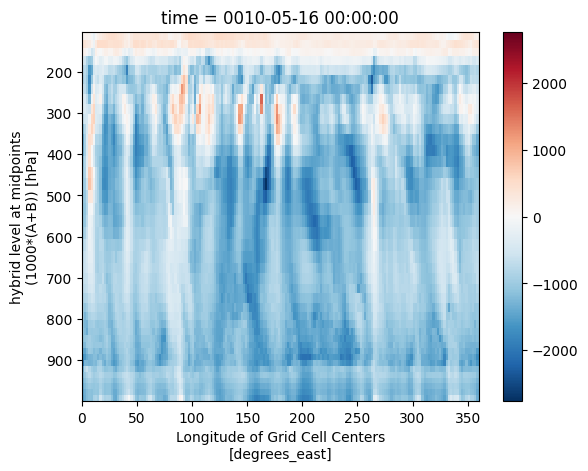

In [11]:
cbar = mse_budget['qr'].plot() 
plt.gca().invert_yaxis()
cbar.set_label('QR')

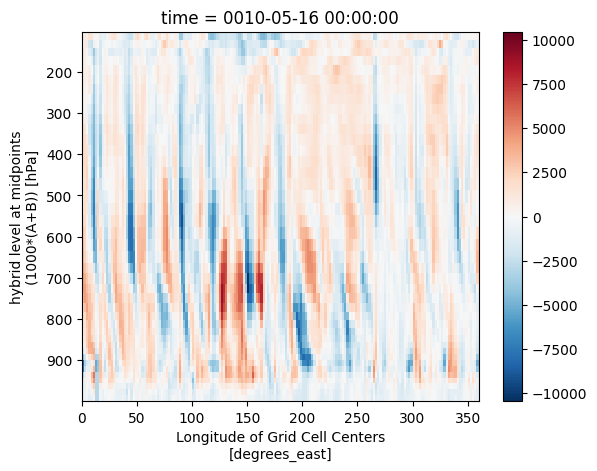

In [12]:
cbar = mse_budget['dyn'].plot()
plt.gca().invert_yaxis()
cbar.set_label('DYN')

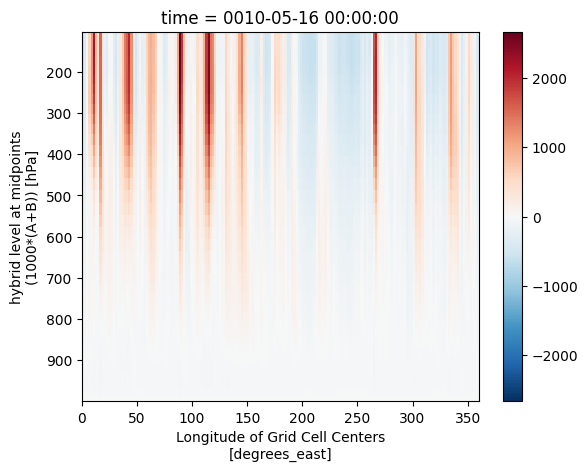

In [13]:
# resi['time'] = resi.time.dt.floor('D')
resi.plot()
plt.gca().invert_yaxis()

In [3]:
fn = '/global/cfs/cdirs/m3312/whannah/2022-RCEROT/E3SM.GNUGPU.ne30pg2.F-MMFXX-RCEROT.BVT.RADNX_1.04/run/E3SM.GNUGPU.ne30pg2.F-MMFXX-RCEROT.BVT.RADNX_1.04.eam.h2.0001-11-01-00000.nc'
ds = xr.open_dataset(fn)
ds 

<xarray.Dataset>
Dimensions:       (ncol: 21600, lev: 60, ilev: 61, swband: 14, lwband: 16,
                   time: 1, nbnd: 2)
Coordinates:
  * lev           (lev) float64 0.07835 0.1411 0.2529 ... 963.6 978.0 992.6
  * ilev          (ilev) float64 0.05588 0.1008 0.1814 ... 970.8 985.3 1e+03
  * swband        (swband) float64 2.925e+03 3.625e+03 ... 4.4e+04 1.71e+03
  * lwband        (lwband) float64 130.0 375.0 565.0 ... 2.535e+03 2.965e+03
  * time          (time) object 0001-11-01 00:00:00
Dimensions without coordinates: ncol, nbnd
Data variables: (12/51)
    lat           (ncol) float64 ...
    lon           (ncol) float64 ...
    area          (ncol) float64 ...
    hyam          (lev) float64 ...
    hybm          (lev) float64 ...
    P0            float64 ...
    ...            ...
    PS            (time, ncol) float32 ...
    Q             (time, lev, ncol) float32 ...
    T             (time, lev, ncol) float32 ...
    U             (time, lev, ncol) float32 ...
    V             (time, lev, ncol) float32 ...
    Z3            (time, lev, ncol) float32 ...
Attributes: (12/19)
    ne:                30
    fv_nphys:          2
    title:             EAM History file information
    source:            E3SM Atmosphere Model
    source_id:         75e954ad3f
    product:           model-output
    ...                ...
    institution_id:    E3SM-Project
    institution:       LLNL (Lawrence Livermore National Laboratory, Livermor...
    contact:           e3sm-data-support@listserv.llnl.gov
    initial_file:      /global/cfs/cdirs/e3sm/inputdata/atm/cam/inic/homme/ea...
    topography_file:   /global/cfs/cdirs/e3sm/inputdata/atm/cam/topo/USGS-gto...
    time_period_freq:  day_1

In [2]:
# test WK plot

# use ERA5 reanalysis data. 
varn = 'olr'
fn = '/pscratch/sd/l/linyaoly/ERA5/reanalysis/fltano120/olr.fltano120.1978to2023based1979to2012.nc'
ds = xr.open_dataset(fn)
olr = ds[varn].sel(time=slice('1979-01-01','2012-12-31'))
olr_flipped = olr.sortby('lat', ascending=True)


In [6]:
import xarray as xr
import MJO_E3SM_util

# calculate WK plot
sym, asym, background, sym_norm, asym_norm, sym_sig, asym_sig = MJO_E3SM_util.wk_analysis(olr_flipped, spd=1, remove_low=False)


size of taper:  (96,)
(343, 179, 47)
(179, 47)


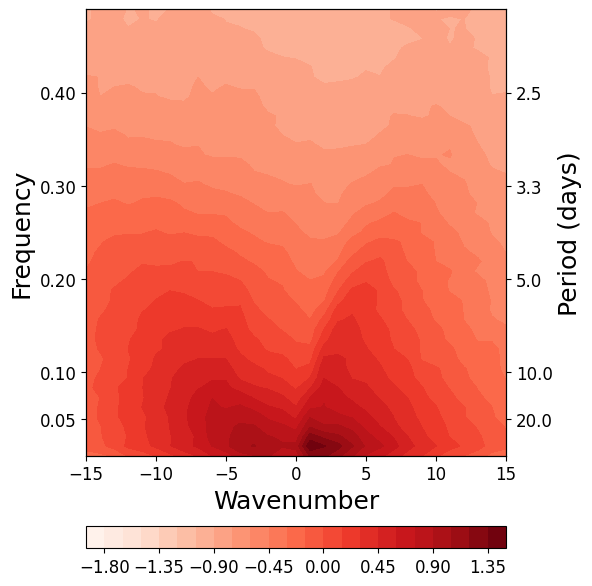

In [9]:
MJO_E3SM_util.wk_plot_sym(sym, logflg=True)

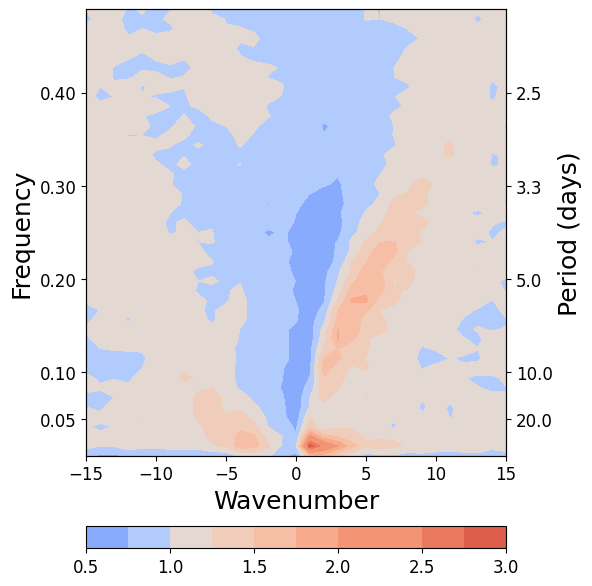

In [8]:
MJO_E3SM_util.wk_plot_sym(sym_norm, logflg=False)

In [90]:
import glob
dirpath = "/pscratch/sd/l/linyaoly/MJO_E3SM/regridded_data/control/"
# Find all .nc files in the directory
nc_files = sorted(glob.glob(f"{dirpath}/*.nc"))

# Initialize an empty list to store the datasets
datasets = []

# Loop over each file to read it into an xarray.Dataset and append it to the list
for file in nc_files[-20:]:
    ds = xr.open_dataset(file)
    datasets.append(ds)

combined_ds = xr.concat(datasets, dim='time')

In [91]:
nc_files

['/pscratch/sd/l/linyaoly/MJO_E3SM/regridded_data/control/E3SM.GNUGPU.ne30pg2.F-MMFXX-RCEROT.BVT.RADNX_1.04.eam.h1.0001-01-01-00000.nc_regridded.nc',
 '/pscratch/sd/l/linyaoly/MJO_E3SM/regridded_data/control/E3SM.GNUGPU.ne30pg2.F-MMFXX-RCEROT.BVT.RADNX_1.04.eam.h1.0001-01-02-00000.nc_regridded.nc',
 '/pscratch/sd/l/linyaoly/MJO_E3SM/regridded_data/control/E3SM.GNUGPU.ne30pg2.F-MMFXX-RCEROT.BVT.RADNX_1.04.eam.h1.0001-01-03-00000.nc_regridded.nc',
 '/pscratch/sd/l/linyaoly/MJO_E3SM/regridded_data/control/E3SM.GNUGPU.ne30pg2.F-MMFXX-RCEROT.BVT.RADNX_1.04.eam.h1.0001-01-04-00000.nc_regridded.nc',
 '/pscratch/sd/l/linyaoly/MJO_E3SM/regridded_data/control/E3SM.GNUGPU.ne30pg2.F-MMFXX-RCEROT.BVT.RADNX_1.04.eam.h1.0001-01-05-00000.nc_regridded.nc',
 '/pscratch/sd/l/linyaoly/MJO_E3SM/regridded_data/control/E3SM.GNUGPU.ne30pg2.F-MMFXX-RCEROT.BVT.RADNX_1.04.eam.h1.0001-01-06-00000.nc_regridded.nc',
 '/pscratch/sd/l/linyaoly/MJO_E3SM/regridded_data/control/E3SM.GNUGPU.ne30pg2.F-MMFXX-RCEROT.BVT.RAD

In [80]:
import cftime

# Function to convert cftime.DatetimeNoLeap to day of year
def cftime_to_doy(cf_datetime_obj):
    start_of_year = cftime.DatetimeNoLeap(cf_datetime_obj.year, 1, 1)
    doy = (cf_datetime_obj - start_of_year).days + 1
    return doy


In [68]:
time_values = combined_ds['time'].values

doy_values = np.array([cftime_to_doy(cfdate) for cfdate in time_values])

In [69]:
combined_ds = combined_ds.assign_coords(doy=doy_values)
combined_ds['doy']

<xarray.DataArray 'doy' (doy: 2913)>
array([137, 137, 137, ..., 135, 135, 136])
Coordinates:
  * doy      (doy) int64 137 137 137 137 137 137 137 ... 135 135 135 135 135 136

In [70]:
sw = combined_ds['FSNT']

In [71]:
sw = sw.assign_coords(doy=("time", doy_values))

In [75]:
def rmv_lowfreq(arr):
    # remove the first three harmonics in the input data
    # arr[time, lat, lon]
    # this is designed for E3SM-MMF data output. The time format is cftime object
    time_values = arr['time'].values
    doy_values = np.array([cftime_to_doy(cfdate) for cfdate in time_values])
    arr = arr.assign_coords(doy=("time", doy_values))

    # annual cycle [doy, lat, lon]
    arr_anu = arr.groupby('doy').mean(dim='time')

    # fft to get smoothed annual cycle
    doy_index = arr_anu.dims.index('doy')
    x_fft = np.fft.rfft(arr_anu.values, axis=doy_index)
    x_fft[4:] = 0.0  # we already know the first dimension is time
    x_re = np.fft.irfft(x_fft, arr_anu.shape[0], axis=doy_index)

    # give the smoothed annual values to a dataarray
    arr_anu.values = x_re  # [doy, lat, lon]

    out = arr.groupby('doy') - arr_anu

    return out

In [76]:
sw 

<xarray.DataArray 'FSNT' (time: 2913, lat: 90, lon: 180)>
array([[[363.04245, 363.07565, 363.14236, ..., 359.58127, 359.58588,
         359.5882 ],
        [359.73703, 359.7047 , 359.63977, ..., 357.4674 , 357.4479 ,
         357.4382 ],
        [372.15973, 372.14392, 372.11212, ..., 336.50787, 336.38892,
         336.3297 ],
        ...,
        [346.90643, 346.85382, 346.74805, ..., 362.9314 , 362.85883,
         362.82272],
        [302.94852, 302.82944, 302.5901 , ..., 364.26633, 364.354  ,
         364.39764],
        [303.68155, 303.77594, 303.96564, ..., 350.0512 , 350.05338,
         350.05444]],

       [[363.94827, 363.96817, 364.0082 , ..., 346.04562, 346.08502,
         346.10464],
        [356.1279 , 356.12683, 356.12466, ..., 347.71652, 347.67563,
         347.65527],
        [369.0001 , 368.9605 , 368.88104, ..., 302.49197, 302.23447,
         302.10632],
...
        [330.7722 , 330.80908, 330.8832 , ..., 294.73282, 294.67838,
         294.65128],
        [343.08942, 343.0918 , 343.09656, ..., 298.89578, 298.9341 ,
         298.9532 ],
        [343.81616, 343.8161 , 343.81595, ..., 294.90768, 294.8978 ,
         294.89288]],

       [[324.12115, 324.07745, 323.98962, ..., 208.62688, 208.90558,
         209.04425],
        [345.19095, 345.181  , 345.16104, ..., 268.57513, 268.5924 ,
         268.601  ],
        [341.00308, 341.02332, 341.06393, ..., 322.08463, 322.41208,
         322.57498],
        ...,
        [329.74783, 329.80255, 329.9125 , ..., 292.84048, 292.80734,
         292.79086],
        [346.76703, 346.76508, 346.76114, ..., 304.98422, 304.92395,
         304.89395],
        [347.4643 , 347.46753, 347.474  , ..., 314.2616 , 314.2625 ,
         314.26294]]], dtype=float32)
Coordinates:
  * lat      (lat) float64 -89.0 -87.0 -85.0 -83.0 -81.0 ... 83.0 85.0 87.0 89.0
  * lon      (lon) float64 1.0 3.0 5.0 7.0 9.0 ... 351.0 353.0 355.0 357.0 359.0
  * time     (time) object 0009-05-17 00:00:00 ... 0010-05-16 00:00:00
    doy      (time) int64 137 137 137 137 137 137 ... 135 135 135 135 135 136
Attributes:
    Sampling_Sequence:  rad_lwsw
    units:              W/m2
    long_name:          Net solar flux at top of model
    cell_methods:       time: mean
    cell_measures:      area: area

In [77]:
out = rmv_lowfreq(sw)

In [78]:
out 

<xarray.DataArray 'FSNT' (time: 2913, lat: 90, lon: 180)>
array([[[  25.7301789 ,   25.76621205,   25.83861382, ...,
           30.72728987,   30.73511027,   30.73903399],
        [  20.42761355,   20.39792153,   20.33825994, ...,
           28.33979203,   28.31435071,   28.30168431],
        [  32.70226518,   32.68504366,   32.65040782, ...,
            6.47503885,    6.35467495,    6.29476903],
        ...,
        [  13.63564881,   13.5987823 ,   13.52464867, ...,
           36.1334147 ,   36.06193309,   36.02637115],
        [ -22.77085993,  -22.87886331,  -23.09596383, ...,
           36.11296438,   36.21094071,   36.25970964],
        [ -19.10799493,  -19.01506658,  -18.82829501, ...,
           21.61944216,   21.6150818 ,   21.61290312]],

       [[  26.63600166,   26.65872914,   26.70445855, ...,
           17.19164534,   17.23425577,   17.25548296],
        [  16.81848269,   16.82004068,   16.82315374, ...,
           18.58890702,   18.54207288,   18.51875584],
        [  29.54262773,   29.50163301,   29.41932872, ...,
          -27.54086081,  -27.79977451,  -27.92861964],
...
        [  -2.72963467,   -2.67493625,   -2.56503482, ...,
          -32.43149094,  -32.48892736,  -32.51751787],
        [  17.87868176,   17.89250205,   17.92024316, ...,
          -28.71752345,  -28.67118999,  -28.64812996],
        [  21.6284486 ,   21.62686945,   21.62367955, ...,
          -32.54100444,  -32.55782108,  -32.56618111]],

       [[ -13.33542123,  -13.37635353,  -13.45861578, ...,
         -120.54988599, -120.26793604, -120.12764172],
        [   5.73048491,    5.72326211,    5.70878424, ...,
          -60.84576684,  -60.83429385,  -60.82857983],
        [   1.26305713,    1.28221736,    1.3206843 , ...,
           -8.37430898,   -8.04920844,   -7.88747849],
        ...,
        [  -3.63924713,   -3.56774262,   -3.4240559 , ...,
          -34.13733579,  -34.17143811,  -34.18839701],
        [  21.30577932,   21.3150872 ,   21.33377096, ...,
          -22.89481125,  -22.94592924,  -22.97136893],
        [  24.98064821,   24.98239334,   24.98588273, ...,
          -13.67532629,  -13.68113614,  -13.68405432]]])
Coordinates:
  * lat      (lat) float64 -89.0 -87.0 -85.0 -83.0 -81.0 ... 83.0 85.0 87.0 89.0
  * lon      (lon) float64 1.0 3.0 5.0 7.0 9.0 ... 351.0 353.0 355.0 357.0 359.0
  * time     (time) object 0009-05-17 00:00:00 ... 0010-05-16 00:00:00
    doy      (time) int64 137 137 137 137 137 137 ... 135 135 135 135 135 136

In [81]:
def rmv_lowfreq(arr):
    # remove the first three harmonics in the input data
    # arr[time, lat, lon]
    # this is designed for E3SM-MMF data output. The time format is cftime object
    time_values = arr['time'].values
    doy_values = np.array([cftime_to_doy(cfdate) for cfdate in time_values])
    arr = arr.assign_coords(doy=("time", doy_values))

    # annual cycle [doy, lat, lon]
    arr_anu = arr.groupby('doy').mean(dim='time')

    # fft to get smoothed annual cycle
    doy_index = arr_anu.dims.index('doy')
    x_fft = np.fft.rfft(arr_anu.values, axis=doy_index)
    x_fft[4:] = 0.0  # we already know the first dimension is time
    x_re = np.fft.irfft(x_fft, arr_anu.shape[0], axis=doy_index)

    # give the smoothed annual values to a dataarray
    arr_anu.values = x_re  # [doy, lat, lon]

    # remove the first three harmonics from raw data
    out = arr.groupby('doy') - arr_anu

    return out

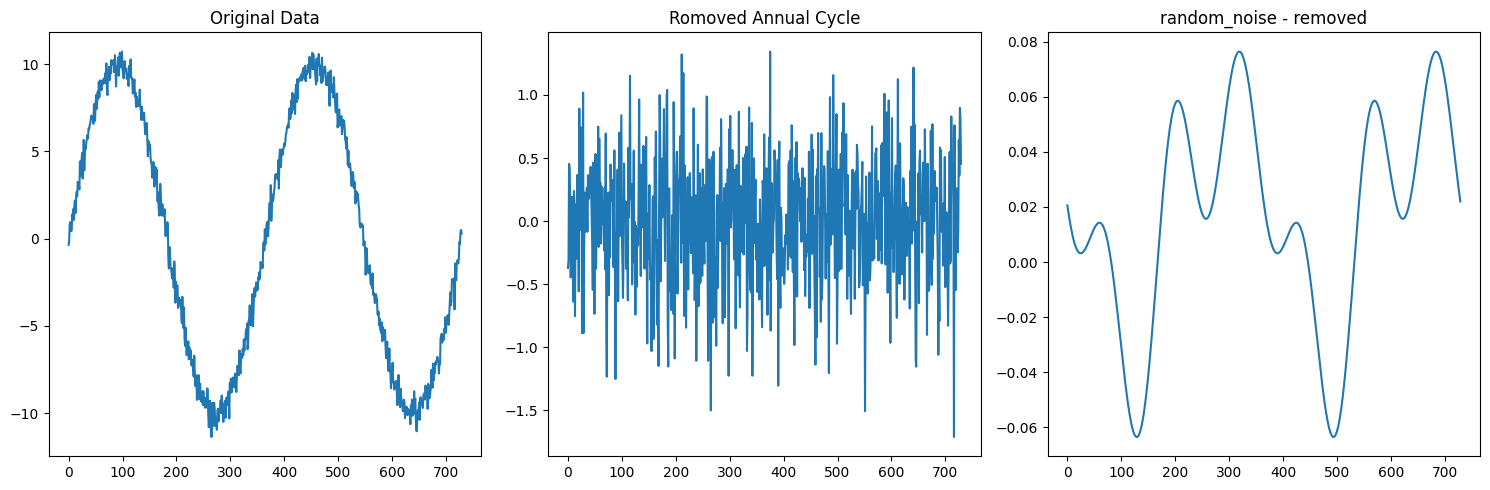

In [88]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

# Generate synthetic data
days_in_year = 365
years = 2
time = xr.cftime_range(start='2000-01-01', periods=days_in_year * years, freq='D', calendar='noleap')
lat = np.linspace(-90, 90, 19)
lon = np.linspace(0, 360, 37)

# Generate a simple annual cycle (sine and cosine wave)
annual_cycle = 10 * np.sin(2 * np.pi * np.arange(days_in_year * years) / days_in_year)
# Add some random noise
random_noise = 0.5 * np.random.randn(days_in_year * years)

# Combine them
combined_signal = annual_cycle + random_noise

# Stretch the 1D array to 3D
data_values = combined_signal[:, np.newaxis, np.newaxis] * np.ones((len(lat), len(lon)))

# Create a DataArray
da = xr.DataArray(
    data_values,
    coords={'time': time, 'lat': lat, 'lon': lon},
    dims=['time', 'lat', 'lon']
)


# Apply your function
result = rmv_lowfreq(da)

# Plot original data, smoothed annual cycle, and the result for a single lat-lon point
plt.figure(figsize=(15, 5))
plt.subplot(131)
plt.title('Original Data')
plt.plot(da.isel(lat=10, lon=10))

plt.subplot(132)
plt.title('Romoved Annual Cycle')
plt.plot(result.isel(lat=10, lon=10))

plt.subplot(133)
plt.title('random_noise - removed')
plt.plot(random_noise - result.isel(lat=10, lon=10))

plt.tight_layout()
plt.show()


In [60]:
sw_anu = sw.groupby('doy').mean(dim='time')

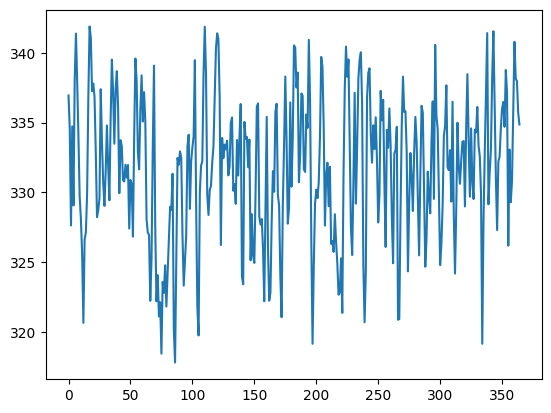

In [39]:
plt.plot(sw_anu)

In [53]:
x_fft = np.fft.rfft(sw_anu.values)
x_fft[4:] = 0
x_re = np.fft.irfft(x_fft, sw_anu.shape[0])

In [55]:
x_fft = np.fft.rfft(sw_anu.values)
x_fft[:4] = 0
x_re1 = np.fft.irfft(x_fft, sw_anu.shape[0])

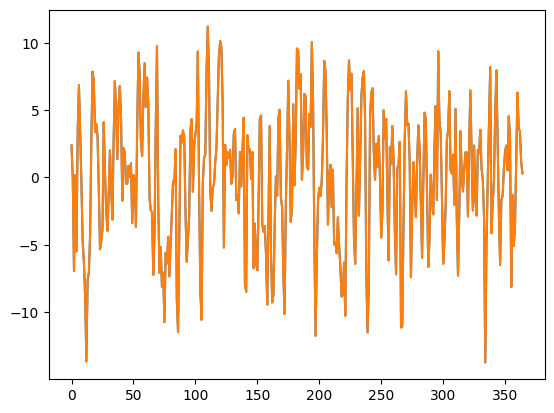

In [56]:
plt.plot(x_re1)
plt.plot(sw_anu.values - x_re)

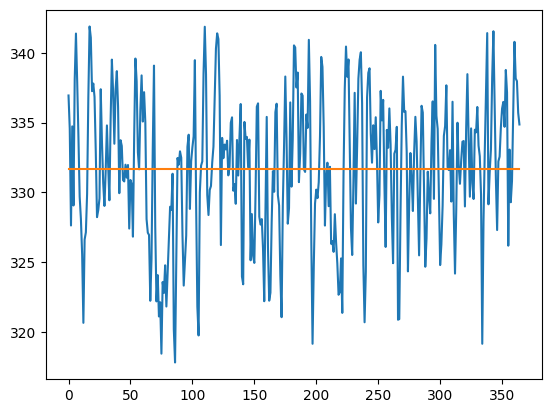

In [43]:
plt.plot(sw_anu)
plt.plot(x_re)

<xarray.DataArray 'doy' (doy: 100)>
array([  3,   3,   3,   3,   3,   3,   3,   3,  36,  36,  36,  36,  36,  36,
        36,  36, 134, 134, 134, 134, 134, 134, 134, 134, 158, 158, 158, 158,
       158, 158, 158, 158, 135, 135, 135, 135, 135, 135, 135, 135,  42,  42,
        42,  42,  42,  42,  42,  42, 187, 187, 187, 187, 187, 187, 187, 187,
        43,  43,  43,  43,  43,  43,  43,  43, 238, 238, 238, 238, 238, 238,
       238, 238, 276, 276, 276, 276, 276, 276, 276, 276, 208, 208, 208, 208,
       208, 208, 208, 208, 181, 181, 181, 181, 181, 181, 181, 181,  82,  82,
        82,  82])
Coordinates:
  * doy      (doy) int64 3 3 3 3 3 3 3 3 36 ... 181 181 181 181 181 82 82 82 82

In [56]:
combined_ds.time[1]

<xarray.DataArray 'time' ()>
array(cftime.DatetimeNoLeap(4, 1, 3, 3, 0, 0, 0, has_year_zero=True),
      dtype=object)
Coordinates:
    time     object 0004-01-03 03:00:00
Attributes:
    long_name:  time
    bounds:     time_bnds

In [57]:
def cftime_to_doy(cf_datetime_obj):
    start_of_year = cftime.DatetimeNoLeap(cf_datetime_obj.year, 1, 1)
    doy = (cf_datetime_obj - start_of_year).days + 1
    return doy


In [59]:
# Convert the array of cftime.DatetimeNoLeap objects to DOY
doy_array = np.array([cftime_to_doy(cf_date) for cf_date in combined_ds.time.values])

print(doy_array)


[ 3  3  3 ... 48 48 48]


In [ ]:
def rmv_lowfreq(arr):
    # remove the first three harmonics in the input data
    # arr[time, lat, lon]

In [7]:
# decompose the input map into symmetric and antisymmetric parts.
def decompose2SymAsym(arr):
    # copy from https://github.com/brianpm/wavenumber_frequency/blob/master/wavenumber_frequency_functions.py
    """Mimic NCL function to decompose into symmetric and asymmetric parts.
    arr: xarra DataArray
    return: symmetric and asymmetric parts. 
    """
    lat_dim = arr.dims.index('lat')
    # print('decompose along axis=', str(lat_dim))
    data_sym = 0.5*(arr.values + np.flip(arr.values, axis=lat_dim))
    data_asy = 0.5*(arr.values - np.flip(arr.values, axis=lat_dim))
    data_sym = xr.DataArray(data_sym, dims=arr.dims, coords=arr.coords, name='sym')
    data_asy = xr.DataArray(data_asy, dims=arr.dims, coords=arr.coords, name='Asym')

    out = arr.copy()  # might not be best to copy, but is safe        
    out.loc[{'lat':arr['lat'][arr['lat']<0]}] = data_sym.isel(lat=data_sym.lat<0)
    out.loc[{'lat':arr['lat'][arr['lat']>0]}] = data_asy.isel(lat=data_asy.lat>0)
    return out

In [21]:
fn = "/pscratch/sd/l/linyaoly/MJO_E3SM/regridded_data/control/E3SM.GNUGPU.ne30pg2.F-MMFXX-RCEROT.BVT.RADNX_1.04.eam.h1.0001-09-01-00000.nc_regridded.nc"
ds = xr.open_dataset(fn)


In [22]:
ds 

<xarray.Dataset>
Dimensions:       (lat: 90, lon: 180, nbnd: 2, time: 8, ilev: 61, lev: 60,
                   lwband: 16, swband: 14)
Coordinates:
  * lat           (lat) float64 -89.0 -87.0 -85.0 -83.0 ... 83.0 85.0 87.0 89.0
  * lon           (lon) float64 1.0 3.0 5.0 7.0 9.0 ... 353.0 355.0 357.0 359.0
  * ilev          (ilev) float64 0.05588 0.1008 0.1814 ... 970.8 985.3 1e+03
  * lev           (lev) float64 0.07835 0.1411 0.2529 ... 963.6 978.0 992.6
  * lwband        (lwband) float64 130.0 375.0 565.0 ... 2.535e+03 2.965e+03
  * swband        (swband) float64 2.925e+03 3.625e+03 ... 4.4e+04 1.71e+03
  * time          (time) object 0001-09-01 00:00:00 ... 0001-09-01 21:00:00
Dimensions without coordinates: nbnd
Data variables: (12/54)
    lat_bnds      (lat, nbnd) float64 ...
    lon_bnds      (lon, nbnd) float64 ...
    gw            (lat) float64 ...
    area          (lat, lon) float64 ...
    FLNS          (time, lat, lon) float32 ...
    FLNT          (time, lat, lon) float32 ...
    ...            ...
    nsbase        int32 ...
    nscur         (time) int32 ...
    nsteph        (time) int32 ...
    sol_tsi       (time) float64 ...
    time_bnds     (time, nbnd) object ...
    time_written  (time) |S8 ...
Attributes: (12/26)
    ne:                        30
    fv_nphys:                  2
    title:                     EAM History file information
    source:                    E3SM Atmosphere Model
    source_id:                 75e954ad3f
    product:                   model-output
    ...                        ...
    remap_hostname:            login13
    remap_version:             5.1.4
    NCO:                       netCDF Operators version 5.1.4 (Homepage = htt...
    nco_openmp_thread_number:  2
    map_file:                  /global/homes/l/linyaoly/MJO_E3SM/remap/map_ne...
    input_file:                /global/cfs/cdirs/m3312/whannah/2022-RCEROT/E3...

In [23]:
ts = ds['TS'].mean(dim='time')

In [24]:
ts.values

array([[300., 300., 300., ..., 300., 300., 300.],
       [300., 300., 300., ..., 300., 300., 300.],
       [300., 300., 300., ..., 300., 300., 300.],
       ...,
       [300., 300., 300., ..., 300., 300., 300.],
       [300., 300., 300., ..., 300., 300., 300.],
       [300., 300., 300., ..., 300., 300., 300.]], dtype=float32)

In [ ]:
# choose a time length

In [2]:
f1 = '/global/cfs/cdirs/m3312/whannah/2022-RCEROT/E3SM.GNUGPU.ne30pg2.F-MMFXX-RCEROT.BVT.RADNX_1.04/run/E3SM.GNUGPU.ne30pg2.F-MMFXX-RCEROT.BVT.RADNX_1.04.eam.h0.0001-01.nc'


In [3]:
xr.open_dataset(f1)

<xarray.Dataset>
Dimensions:           (ncol: 21600, lev: 60, ilev: 61, swband: 14, lwband: 16,
                       time: 1, nbnd: 2)
Coordinates:
  * lev               (lev) float64 0.07835 0.1411 0.2529 ... 963.6 978.0 992.6
  * ilev              (ilev) float64 0.05588 0.1008 0.1814 ... 970.8 985.3 1e+03
  * swband            (swband) float64 2.925e+03 3.625e+03 ... 4.4e+04 1.71e+03
  * lwband            (lwband) float64 130.0 375.0 565.0 ... 2.535e+03 2.965e+03
  * time              (time) object 0001-02-01 00:00:00
Dimensions without coordinates: ncol, nbnd
Data variables: (12/151)
    lat               (ncol) float64 ...
    lon               (ncol) float64 ...
    area              (ncol) float64 ...
    hyam              (lev) float64 ...
    hybm              (lev) float64 ...
    P0                float64 ...
    ...                ...
    VQ                (time, lev, ncol) float32 ...
    VT                (time, lev, ncol) float32 ...
    VU                (time, lev, ncol) float32 ...
    VV                (time, lev, ncol) float32 ...
    Z3                (time, lev, ncol) float32 ...
    hstobie_linoz     (time, lev, ncol) float32 ...
Attributes: (12/19)
    ne:                30
    fv_nphys:          2
    title:             EAM History file information
    source:            E3SM Atmosphere Model
    source_id:         75e954ad3f
    product:           model-output
    ...                ...
    institution_id:    E3SM-Project
    institution:       LLNL (Lawrence Livermore National Laboratory, Livermor...
    contact:           e3sm-data-support@listserv.llnl.gov
    initial_file:      /global/cfs/cdirs/e3sm/inputdata/atm/cam/inic/homme/ea...
    topography_file:   /global/cfs/cdirs/e3sm/inputdata/atm/cam/topo/USGS-gto...
    time_period_freq:  month_1

In [4]:
f2 = '/global/cfs/cdirs/m3312/whannah/2022-RCEROT/E3SM.GNUGPU.ne30pg2.F-MMFXX-RCEROT.BVT.RADNX_1.04/run/E3SM.GNUGPU.ne30pg2.F-MMFXX-RCEROT.BVT.RADNX_1.04.eam.h1.0001-01-01-00000.nc'
xr.open_dataset(f2)

<xarray.Dataset>
Dimensions:       (ncol: 21600, lev: 60, ilev: 61, swband: 14, lwband: 16,
                   time: 8, nbnd: 2)
Coordinates:
  * lev           (lev) float64 0.07835 0.1411 0.2529 ... 963.6 978.0 992.6
  * ilev          (ilev) float64 0.05588 0.1008 0.1814 ... 970.8 985.3 1e+03
  * swband        (swband) float64 2.925e+03 3.625e+03 ... 4.4e+04 1.71e+03
  * lwband        (lwband) float64 130.0 375.0 565.0 ... 2.535e+03 2.965e+03
  * time          (time) object 0001-01-01 00:00:00 ... 0001-01-01 21:00:00
Dimensions without coordinates: ncol, nbnd
Data variables: (12/53)
    lat           (ncol) float64 ...
    lon           (ncol) float64 ...
    area          (ncol) float64 ...
    hyam          (lev) float64 ...
    hybm          (lev) float64 ...
    P0            float64 ...
    ...            ...
    U200          (time, ncol) float32 ...
    U850          (time, ncol) float32 ...
    UBOT          (time, ncol) float32 ...
    V200          (time, ncol) float32 ...
    V850          (time, ncol) float32 ...
    VBOT          (time, ncol) float32 ...
Attributes: (12/19)
    ne:                30
    fv_nphys:          2
    title:             EAM History file information
    source:            E3SM Atmosphere Model
    source_id:         75e954ad3f
    product:           model-output
    ...                ...
    institution_id:    E3SM-Project
    institution:       LLNL (Lawrence Livermore National Laboratory, Livermor...
    contact:           e3sm-data-support@listserv.llnl.gov
    initial_file:      /global/cfs/cdirs/e3sm/inputdata/atm/cam/inic/homme/ea...
    topography_file:   /global/cfs/cdirs/e3sm/inputdata/atm/cam/topo/USGS-gto...
    time_period_freq:  hour_3

In [9]:
f3 = '/global/cfs/cdirs/m3312/whannah/2022-RCEROT/E3SM.GNUGPU.ne30pg2.F-MMFXX-RCEROT.BVT.RADNX_1.04/run/E3SM.GNUGPU.ne30pg2.F-MMFXX-RCEROT.BVT.RADNX_1.04.eam.h2.0001-01-01-00000.nc'
xr.open_dataset(f3)

<xarray.Dataset>
Dimensions:       (ncol: 21600, lev: 60, ilev: 61, swband: 14, lwband: 16,
                   time: 1, nbnd: 2)
Coordinates:
  * lev           (lev) float64 0.07835 0.1411 0.2529 ... 963.6 978.0 992.6
  * ilev          (ilev) float64 0.05588 0.1008 0.1814 ... 970.8 985.3 1e+03
  * swband        (swband) float64 2.925e+03 3.625e+03 ... 4.4e+04 1.71e+03
  * lwband        (lwband) float64 130.0 375.0 565.0 ... 2.535e+03 2.965e+03
  * time          (time) object 0001-01-01 00:00:00
Dimensions without coordinates: ncol, nbnd
Data variables: (12/51)
    lat           (ncol) float64 ...
    lon           (ncol) float64 ...
    area          (ncol) float64 ...
    hyam          (lev) float64 ...
    hybm          (lev) float64 ...
    P0            float64 ...
    ...            ...
    PS            (time, ncol) float32 ...
    Q             (time, lev, ncol) float32 ...
    T             (time, lev, ncol) float32 ...
    U             (time, lev, ncol) float32 ...
    V             (time, lev, ncol) float32 ...
    Z3            (time, lev, ncol) float32 ...
Attributes: (12/19)
    ne:                30
    fv_nphys:          2
    title:             EAM History file information
    source:            E3SM Atmosphere Model
    source_id:         75e954ad3f
    product:           model-output
    ...                ...
    institution_id:    E3SM-Project
    institution:       LLNL (Lawrence Livermore National Laboratory, Livermor...
    contact:           e3sm-data-support@listserv.llnl.gov
    initial_file:      /global/cfs/cdirs/e3sm/inputdata/atm/cam/inic/homme/ea...
    topography_file:   /global/cfs/cdirs/e3sm/inputdata/atm/cam/topo/USGS-gto...
    time_period_freq:  day_1

In [2]:
fn = '/global/cfs/cdirs/m3312/whannah/2022-RCEROT/E3SM.GNUGPU.ne30pg2.F-MMFXX-RCEROT.BVT.RADNX_1.04/run/E3SM.GNUGPU.ne30pg2.F-MMFXX-RCEROT.BVT.RADNX_1.04.eam.h1.0001-01-01-00000.nc'
ds = xr.open_dataset(fn)
ds 

<xarray.Dataset>
Dimensions:       (ncol: 21600, lev: 60, ilev: 61, swband: 14, lwband: 16,
                   time: 8, nbnd: 2)
Coordinates:
  * lev           (lev) float64 0.07835 0.1411 0.2529 ... 963.6 978.0 992.6
  * ilev          (ilev) float64 0.05588 0.1008 0.1814 ... 970.8 985.3 1e+03
  * swband        (swband) float64 2.925e+03 3.625e+03 ... 4.4e+04 1.71e+03
  * lwband        (lwband) float64 130.0 375.0 565.0 ... 2.535e+03 2.965e+03
  * time          (time) object 0001-01-01 00:00:00 ... 0001-01-01 21:00:00
Dimensions without coordinates: ncol, nbnd
Data variables: (12/53)
    lat           (ncol) float64 ...
    lon           (ncol) float64 ...
    area          (ncol) float64 ...
    hyam          (lev) float64 ...
    hybm          (lev) float64 ...
    P0            float64 ...
    ...            ...
    U200          (time, ncol) float32 ...
    U850          (time, ncol) float32 ...
    UBOT          (time, ncol) float32 ...
    V200          (time, ncol) float32 ...
    V850          (time, ncol) float32 ...
    VBOT          (time, ncol) float32 ...
Attributes: (12/19)
    ne:                30
    fv_nphys:          2
    title:             EAM History file information
    source:            E3SM Atmosphere Model
    source_id:         75e954ad3f
    product:           model-output
    ...                ...
    institution_id:    E3SM-Project
    institution:       LLNL (Lawrence Livermore National Laboratory, Livermor...
    contact:           e3sm-data-support@listserv.llnl.gov
    initial_file:      /global/cfs/cdirs/e3sm/inputdata/atm/cam/inic/homme/ea...
    topography_file:   /global/cfs/cdirs/e3sm/inputdata/atm/cam/topo/USGS-gto...
    time_period_freq:  hour_3

In [15]:
u850 = ds['U850']
lat = ds['lat']
lon = ds['lon']

In [16]:
u850

<xarray.DataArray 'U850' (time: 8, ncol: 21600)>
[172800 values with dtype=float32]
Coordinates:
  * time     (time) object 0001-01-01 00:00:00 ... 0001-01-01 21:00:00
Dimensions without coordinates: ncol
Attributes:
    units:         m/s
    long_name:     Zonal wind at 850 mbar pressure surface
    cell_methods:  time: mean

In [17]:
lon

<xarray.DataArray 'lon' (ncol: 21600)>
[21600 values with dtype=float64]
Dimensions without coordinates: ncol
Attributes:
    long_name:  longitude
    units:      degrees_east

In [24]:
lat.values

array([-34.91143916, -35.58196515, -33.51497835, ...,  36.66411307,
        36.66411307,  35.96577012])

In [25]:
lon.values

array([315.74071604, 317.24067332, 315.74135189, ..., 133.49916029,
       136.50083971, 135.        ])